# Исследование ДТП

**Описание**

Вам предлагается поработать над задачей исследования данных о дорожно-транспортных происшествиях (ДТП).

Заказчиком (Оунером задачи) выступает проект «Карта ДТП» https://dtp-stat.ru/ — некоммерческий проект, посвященный проблеме дорожно-транспортных происшествий в России. Это платформа сбора данных о ДТП, бесплатный и открытый сервис аналитики ДТП.

**Цель проекта** - провести глубокий анализ данных, сформулировать и проверить гипотезы, опираясь на доступные признаки.

## 1. Парсинг данных

In [7]:
import os
import pandas as pd
import re
import requests
import matplotlib.pyplot as plt
from pandas_geojson import read_geojson
import datetime as dt
import dill as pickle
import json

## 2. Формируем единый датафрейм

In [2]:
def read_geojson(filename):
    with open(f'{filename}', encoding= 'utf-8') as response:
        geo_json = json.load(response)
    return geo_json

In [3]:
# Прочитаем файлы в дирректории dtp и переведем первый файл в датафрейм
list_file = os.listdir('dtp')

# Посчитаем общее число скачанных файлов.
print(f'Общее число файлов в директории dtp {len(list_file)}.')

geo_json = read_geojson(os.path.join('dtp', list_file[0]))

Общее число файлов в директории dtp 85.


In [4]:
geo_json.keys()

dict_keys(['type', 'features'])

In [5]:
geo_json['type']

'FeatureCollection'

In [6]:
# Смотрим структуру файла.

geo_json['features'][0]

{'type': 'Feature',
 'geometry': {'type': 'Point', 'coordinates': [83.7879, 53.3912]},
 'properties': {'id': 2869171,
  'tags': ['Дорожно-транспортные происшествия'],
  'light': 'Светлое время суток',
  'point': {'lat': 53.3912, 'long': 83.7879},
  'nearby': ['Жилые дома индивидуальной застройки'],
  'region': 'Барнаул',
  'scheme': '830',
  'address': None,
  'weather': ['Ясно'],
  'category': 'Наезд на пешехода',
  'datetime': '2023-05-24 19:30:00',
  'severity': 'Легкий',
  'vehicles': [{'year': 2015,
    'brand': 'Прочие марки ТС',
    'color': 'Черный',
    'model': 'Прочие марки и модели ТС',
    'category': 'Мопеды с двигателем внутреннего сгорания менее 50 см. куб.',
    'participants': [{'role': 'Водитель',
      'gender': 'Мужской',
      'violations': ['Управление мопедом лицом моложе 16 лет',
       'Управление ТС лицом, не имеющим права на управление ТС',
       'Оставление места ДТП',
       'Невыполнение требований обеспечения безопасности при начале движения'],
      'h

In [7]:
# Попытка прочитать сразу не удалась.

pd.DataFrame(geo_json).head()

,type,features
0,FeatureCollection,"{'type': 'Feature', 'geometry': {'type': 'Poin..."
1,FeatureCollection,"{'type': 'Feature', 'geometry': {'type': 'Poin..."
2,FeatureCollection,"{'type': 'Feature', 'geometry': {'type': 'Poin..."
3,FeatureCollection,"{'type': 'Feature', 'geometry': {'type': 'Poin..."
4,FeatureCollection,"{'type': 'Feature', 'geometry': {'type': 'Poin..."


In [8]:
# Используем нормализацию json из бибилотеки pandas - json_normalize

df = pd.json_normalize(geo_json['features'])

# Прочитаем первые пять строк и транспонируем таблицу для удобства.

df.head().T

,0,1,2,3,4
type,Feature,Feature,Feature,Feature,Feature
geometry.type,Point,Point,Point,Point,Point
geometry.coordinates,"[83.7879, 53.3912]","[83.666389, 53.345833]","[83.39688, 53.19706]","[83.7142, 53.3764]","[83.794366, 53.343071]"
properties.id,2869171,2320091,2321011,2576909,2575209
properties.tags,[Дорожно-транспортные происшествия],"[Дорожно-транспортные происшествия, ДТП и пост...","[Дорожно-транспортные происшествия, ДТП и пост...",[Дорожно-транспортные происшествия],[Дорожно-транспортные происшествия]
properties.light,Светлое время суток,Светлое время суток,Светлое время суток,Светлое время суток,Светлое время суток
properties.point.lat,53.3912,53.345833,53.19706,53.3764,53.343071
properties.point.long,83.7879,83.666389,83.39688,83.7142,83.794366
properties.nearby,[Жилые дома индивидуальной застройки],"[Многоквартирные жилые дома, Внутридворовая те...","[Административные здания, Остановка общественн...","[Выезд с прилегающей территории, Административ...","[Многоквартирные жилые дома, Жилые дома индиви..."
properties.region,Барнаул,Барнаул,Барнаул,Барнаул,Барнаул


In [9]:
# Смотрим общую информацию.

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25665 entries, 0 to 25664
Data columns (total 24 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   type                               25665 non-null  object 
 1   geometry.type                      25665 non-null  object 
 2   geometry.coordinates               25665 non-null  object 
 3   properties.id                      25665 non-null  int64  
 4   properties.tags                    25665 non-null  object 
 5   properties.light                   25665 non-null  object 
 6   properties.point.lat               25649 non-null  float64
 7   properties.point.long              25649 non-null  float64
 8   properties.nearby                  25665 non-null  object 
 9   properties.region                  25665 non-null  object 
 10  properties.scheme                  25230 non-null  object 
 11  properties.address                 24325 non-null  obj

In [10]:
# Поправляем названия столбцов и убираем певые два
df = df.drop([col for col in df.columns if 'type' in col], axis =1)
df.columns = [col.split('.')[-1] for col in df.columns]
df.columns

Index(['coordinates', 'id', 'tags', 'light', 'lat', 'long', 'nearby', 'region',
       'scheme', 'address', 'weather', 'category', 'datetime', 'severity',
       'vehicles', 'dead_count', 'participants', 'injured_count',
       'parent_region', 'road_conditions', 'participants_count',
       'participant_categories'],
      dtype='object')

Часть данных находится в форматах json или list. Эти данные необходимо выделить в отдельный датафрейм (для json) или перевести в более удобный формат(list).

Основные проблемы:
- Есть списки;
- Есть json;
- Есть столбец scheme, которого нет в описании.
- Столбец даты не приведен к нужному формату.

Решаем проблемы:
- Пробуем разделить списки;
- Разделяем json;
- Оставляем scheme, приведя пропуски к единому типу.
- Приводим столбец даты в нужный формат.

In [11]:
# Создадим функция для исследования данных (Первый шаг EDA).

def first_look_data(data):
    display(data.head())
    print('Колонки')
    print(data.columns)
#     Данный print позволяет красиво выделять данные, 
#     не набирая при этом 50 раз * или -)))

    print(50*'-')
    print('Содержимое колонок')
    print(20*'*')
    
# Многие из вас используют data.columns,
# но можно и так.
    for col in data:
        print(col)
# Не все колонки могут быть прочитаны
# unique и nunique
        try:
            print(data[col].unique())
            print(data[col].nunique())
            
            
        except TypeError:
            print('Списковое исключение')
            
            print(data[col][:5])
            
           
    
        print(20*'*')
    print('Общая информация')
    print(data.info())
        
    print(50*"-")
    print('Пропуски')
    print(data.isna().sum())
    print(50*"-")

In [12]:
# Пишем функцию для выделения json в отдельный датафрейм

# data_out = pd.json_normalize(data.explode(col)[col].dropna())
# data_out = pd.json_normalize(data.explode(col)[col])

def normalize_json_to_data(data, col):
    
    data_out = pd.json_normalize(data.explode(col)[col].dropna())
    
    
#     Все таблицы связаны между собой через id родительской таблицы.

    data_out = pd.concat([
        pd.DataFrame(data.explode(col)['id'].values, columns=['id']),
        data_out
    ],
                            axis=1)
    return data_out

In [13]:
first_look_data(df)

,coordinates,id,tags,light,lat,long,nearby,region,scheme,address,...,datetime,severity,vehicles,dead_count,participants,injured_count,parent_region,road_conditions,participants_count,participant_categories
0,"[83.7879, 53.3912]",2869171,[Дорожно-транспортные происшествия],Светлое время суток,53.391200,83.787900,[Жилые дома индивидуальной застройки],Барнаул,830,None,...,2023-05-24 19:30:00,Легкий,"[{'year': 2015, 'brand': 'Прочие марки ТС', 'c...",0,"[{'role': 'Пешеход', 'gender': 'Мужской', 'vio...",1,Алтайский край,[Сухое],2,"[Все участники, Пешеходы, Мотоциклисты]"
1,"[83.666389, 53.345833]",2320091,"[Дорожно-транспортные происшествия, ДТП и пост...",Светлое время суток,53.345833,83.666389,"[Многоквартирные жилые дома, Внутридворовая те...",Барнаул,880,"г Барнаул, ул Сиреневая, 11",...,2015-09-16 13:00:00,Легкий,"[{'year': 2002, 'brand': 'TOYOTA', 'color': 'С...",0,[],1,Алтайский край,[Сухое],2,"[Дети, Все участники]"
2,"[83.39688, 53.19706]",2321011,"[Дорожно-транспортные происшествия, ДТП и пост...",Светлое время суток,53.197060,83.396880,"[Административные здания, Остановка общественн...",Барнаул,960,"г Барнаул, ул Попова, 165",...,2017-08-25 15:30:00,Легкий,"[{'year': 1981, 'brand': 'DAIMLER', 'color': '...",0,[],1,Алтайский край,[Сухое],3,"[Дети, Все участники]"
3,"[83.7142, 53.3764]",2576909,[Дорожно-транспортные происшествия],Светлое время суток,53.376400,83.714200,"[Выезд с прилегающей территории, Административ...",Барнаул,130,"г Барнаул, ул Петра Сухова, 83 А",...,2021-05-29 19:40:00,Тяжёлый,"[{'year': 2001, 'brand': 'HONDA', 'color': 'Се...",0,[],1,Алтайский край,"[Сухое, Отсутствие, плохая различимость горизо...",3,"[Все участники, Мотоциклисты]"
4,"[83.794366, 53.343071]",2575209,[Дорожно-транспортные происшествия],Светлое время суток,53.343071,83.794366,"[Многоквартирные жилые дома, Жилые дома индиви...",Барнаул,500,"г Барнаул, ул Партизанская, 26",...,2021-05-25 16:40:00,Легкий,"[{'year': 2014, 'brand': 'NISSAN', 'color': 'С...",0,[],1,Алтайский край,"[Сухое, Отсутствие, плохая различимость горизо...",2,[Все участники]


Колонки
Index(['coordinates', 'id', 'tags', 'light', 'lat', 'long', 'nearby', 'region',
       'scheme', 'address', 'weather', 'category', 'datetime', 'severity',
       'vehicles', 'dead_count', 'participants', 'injured_count',
       'parent_region', 'road_conditions', 'participants_count',
       'participant_categories'],
      dtype='object')
--------------------------------------------------
Содержимое колонок
********************
coordinates
Списковое исключение
0        [83.7879, 53.3912]
1    [83.666389, 53.345833]
2      [83.39688, 53.19706]
3        [83.7142, 53.3764]
4    [83.794366, 53.343071]
Name: coordinates, dtype: object
********************
id
[2869171 2320091 2321011 ... 2314775 2315405 2316243]
25665
********************
tags
Списковое исключение
0                  [Дорожно-транспортные происшествия]
1    [Дорожно-транспортные происшествия, ДТП и пост...
2    [Дорожно-транспортные происшествия, ДТП и пост...
3                  [Дорожно-транспортные происшествия]
4 

In [14]:
# Датафрейм для машин.

df_vehicles = normalize_json_to_data(df, 'vehicles').reset_index(drop=True)

# Датафрейм для пассажиров машин.

df_vehicles_participants = normalize_json_to_data(
    df_vehicles, 'participants').reset_index(drop=True)

# Датафрейм для пешеходов.
# Дополнительно удалим все пустые строки, так как там нет пешеходов.
df_footer = normalize_json_to_data(
    df, 'participants').dropna().reset_index(drop=True)

In [15]:
first_look_data(df_vehicles)

,id,year,brand,color,model,category,participants
0,2869171,2015.0,Прочие марки ТС,Черный,Прочие марки и модели ТС,Мопеды с двигателем внутреннего сгорания менее...,"[{'role': 'Водитель', 'gender': 'Мужской', 'vi..."
1,2320091,2002.0,TOYOTA,Серый,Corolla,"С-класс (малый средний, компактный) до 4,3 м","[{'role': 'Водитель', 'gender': 'Мужской', 'vi..."
2,2321011,1981.0,DAIMLER,Многоцветный,Прочие модели DAIMLER,Одноэтажные длиной от 8 до 12 м,"[{'role': 'Водитель', 'gender': 'Мужской', 'vi..."
3,2576909,2001.0,HONDA,Серый,Torneo,"В-класс (малый) до 3,9 м","[{'role': 'Водитель', 'gender': 'Женский', 'vi..."
4,2576909,1987.0,HONDA,Синий,Magna,Мотоциклы,"[{'role': 'Пассажир', 'gender': 'Женский', 'vi..."


Колонки
Index(['id', 'year', 'brand', 'color', 'model', 'category', 'participants'], dtype='object')
--------------------------------------------------
Содержимое колонок
********************
id
[2869171 2320091 2321011 ... 2314775 2315405 2316243]
25665
********************
year
[2.015e+03 2.002e+03 1.981e+03 2.001e+03 1.987e+03 2.014e+03 2.003e+03
 2.019e+03 2.007e+03 2.000e+03 1.991e+03 1.994e+03 2.012e+03 1.996e+03
 2.017e+03       nan 1.983e+03 2.004e+03 1.998e+03 1.992e+03 2.005e+03
 2.008e+03 2.006e+03 2.010e+03 1.986e+03 1.999e+03 2.016e+03 2.011e+03
 2.020e+03 1.988e+03 1.993e+03 1.995e+03 2.021e+03 2.022e+03 2.009e+03
 1.997e+03 2.013e+03 1.990e+03 2.018e+03 1.989e+03 1.985e+03 1.978e+03
 1.984e+03 1.982e+03 1.980e+03 2.023e+03 1.974e+03 1.979e+03 1.977e+03
 1.971e+03 1.976e+03 1.965e+03 1.975e+03 1.951e+03 1.963e+03 1.960e+03
 1.968e+03 1.970e+03 1.973e+03 1.000e+00 1.948e+03 1.972e+03 1.962e+03
 1.969e+03 1.958e+03 1.956e+03 1.950e+03 1.966e+03 1.900e+03 1.967e+03
 1.955e+0

In [16]:
first_look_data(df_vehicles_participants)

,id,role,gender,violations,health_status,years_of_driving_experience
0,2869171,Водитель,Мужской,"[Управление мопедом лицом моложе 16 лет, Управ...",Не пострадал,NaN
1,2320091,Водитель,Мужской,"[Несоблюдение условий, разрешающих движение тр...",Не пострадал,14.0
2,2321011,Водитель,Мужской,[],Не пострадал,25.0
3,2321011,Пассажир,Женский,[Нарушение правил пользования общественным тра...,Не пострадал,NaN
4,2321011,Пассажир,Женский,[],"Раненый, находящийся (находившийся) на амбула...",NaN


Колонки
Index(['id', 'role', 'gender', 'violations', 'health_status',
       'years_of_driving_experience'],
      dtype='object')
--------------------------------------------------
Содержимое колонок
********************
id
[2869171 2320091 2321011 ... 2314775 2315405 2316243]
25665
********************
role
['Водитель' 'Пассажир' 'Велосипедист' 'Пешеход' nan]
4
********************
gender
['Мужской' 'Женский' None nan]
2
********************
violations
Списковое исключение
0    [Управление мопедом лицом моложе 16 лет, Управ...
1    [Несоблюдение условий, разрешающих движение тр...
2                                                   []
3    [Нарушение правил пользования общественным тра...
4                                                   []
Name: violations, dtype: object
********************
health_status
['Не пострадал'
 'Раненый, находящийся (находившийся)  на амбулаторном лечении, либо которому по характеру полученных травм обозначена необходимость амбулаторного лечения (вне за

In [17]:
first_look_data(df_footer)

,id,role,gender,violations,health_status
0,2869171,Пешеход,Мужской,[],"Раненый, находящийся (находившийся) на амбулат..."
1,2320091,Пешеход,Женский,[],"Раненый, находящийся (находившийся) на амбулат..."
2,2321011,Пешеход,Женский,[],"Раненый, находящийся (находившийся) на стацион..."
3,2576909,Пешеход,Женский,[],"Раненый, находящийся (находившийся) на амбулат..."
4,2575209,Пешеход,Мужской,[],"Раненый, находящийся (находившийся) на амбула..."


Колонки
Index(['id', 'role', 'gender', 'violations', 'health_status'], dtype='object')
--------------------------------------------------
Содержимое колонок
********************
id
[2869171 2320091 2321011 ... 2515945 2547781 2547795]
9189
********************
role
['Пешеход'
 'Пешеход, перед ДТП находившийся в (на) ТС в качестве водителя или пешеход, перед ДТП находившийся в (на) ТС в качестве пассажира']
2
********************
gender
['Мужской' 'Женский']
2
********************
violations
Списковое исключение
0    []
1    []
2    []
3    []
4    []
Name: violations, dtype: object
********************
health_status
['Раненый, находящийся (находившийся) на амбулаторном лечении, либо в условиях дневного стационара'
 'Раненый, находящийся (находившийся) на стационарном лечении'
 'Раненый, находящийся (находившийся)  на амбулаторном лечении, либо которому по характеру полученных травм обозначена необходимость амбулаторного лечения (вне зависимости от его фактического прохождения)'
 'Получ

## Списки

In [18]:
# Перевод в формат дат.
df['datetime'] = pd.to_datetime(df['datetime'])

In [19]:
# Удяляем участников в транспортном средстве.

df_vehicles = df_vehicles.drop(['participants'],axis=1)

In [20]:
df_vehicles_participants.info()
df_vehicles_participants.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52466 entries, 0 to 52465
Data columns (total 6 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   id                           52466 non-null  int64  
 1   role                         52223 non-null  object 
 2   gender                       51141 non-null  object 
 3   violations                   52223 non-null  object 
 4   health_status                52069 non-null  object 
 5   years_of_driving_experience  32115 non-null  float64
dtypes: float64(1), int64(1), object(4)
memory usage: 2.4+ MB


,id,role,gender,violations,health_status,years_of_driving_experience
0,2869171,Водитель,Мужской,"[Управление мопедом лицом моложе 16 лет, Управ...",Не пострадал,NaN
1,2320091,Водитель,Мужской,"[Несоблюдение условий, разрешающих движение тр...",Не пострадал,14.0
2,2321011,Водитель,Мужской,[],Не пострадал,25.0
3,2321011,Пассажир,Женский,[Нарушение правил пользования общественным тра...,Не пострадал,NaN
4,2321011,Пассажир,Женский,[],"Раненый, находящийся (находившийся) на амбула...",NaN


In [21]:
df_footer.info()
df_footer.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9401 entries, 0 to 9400
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   id             9401 non-null   int64 
 1   role           9401 non-null   object
 2   gender         9401 non-null   object
 3   violations     9401 non-null   object
 4   health_status  9401 non-null   object
dtypes: int64(1), object(4)
memory usage: 367.4+ KB


,id,role,gender,violations,health_status
0,2869171,Пешеход,Мужской,[],"Раненый, находящийся (находившийся) на амбулат..."
1,2320091,Пешеход,Женский,[],"Раненый, находящийся (находившийся) на амбулат..."
2,2321011,Пешеход,Женский,[],"Раненый, находящийся (находившийся) на стацион..."
3,2576909,Пешеход,Женский,[],"Раненый, находящийся (находившийся) на амбулат..."
4,2575209,Пешеход,Мужской,[],"Раненый, находящийся (находившийся) на амбула..."


In [22]:
#  Объединим таблицы df_footer и df_vehicles_participants


df_foot_part = pd.concat([df_vehicles_participants,df_footer]).copy().reset_index(drop=True)

In [23]:
first_look_data(df_foot_part)

,id,role,gender,violations,health_status,years_of_driving_experience
0,2869171,Водитель,Мужской,"[Управление мопедом лицом моложе 16 лет, Управ...",Не пострадал,NaN
1,2320091,Водитель,Мужской,"[Несоблюдение условий, разрешающих движение тр...",Не пострадал,14.0
2,2321011,Водитель,Мужской,[],Не пострадал,25.0
3,2321011,Пассажир,Женский,[Нарушение правил пользования общественным тра...,Не пострадал,NaN
4,2321011,Пассажир,Женский,[],"Раненый, находящийся (находившийся) на амбула...",NaN


Колонки
Index(['id', 'role', 'gender', 'violations', 'health_status',
       'years_of_driving_experience'],
      dtype='object')
--------------------------------------------------
Содержимое колонок
********************
id
[2869171 2320091 2321011 ... 2314775 2315405 2316243]
25665
********************
role
['Водитель' 'Пассажир' 'Велосипедист' 'Пешеход' nan
 'Пешеход, перед ДТП находившийся в (на) ТС в качестве водителя или пешеход, перед ДТП находившийся в (на) ТС в качестве пассажира']
5
********************
gender
['Мужской' 'Женский' None nan]
2
********************
violations
Списковое исключение
0    [Управление мопедом лицом моложе 16 лет, Управ...
1    [Несоблюдение условий, разрешающих движение тр...
2                                                   []
3    [Нарушение правил пользования общественным тра...
4                                                   []
Name: violations, dtype: object
********************
health_status
['Не пострадал'
 'Раненый, находящийся (находи

## Итого

In [24]:
# Первый датафрейм
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25665 entries, 0 to 25664
Data columns (total 22 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   coordinates             25665 non-null  object        
 1   id                      25665 non-null  int64         
 2   tags                    25665 non-null  object        
 3   light                   25665 non-null  object        
 4   lat                     25649 non-null  float64       
 5   long                    25649 non-null  float64       
 6   nearby                  25665 non-null  object        
 7   region                  25665 non-null  object        
 8   scheme                  25230 non-null  object        
 9   address                 24325 non-null  object        
 10  weather                 25665 non-null  object        
 11  category                25665 non-null  object        
 12  datetime                25665 non-null  dateti

,coordinates,id,tags,light,lat,long,nearby,region,scheme,address,...,datetime,severity,vehicles,dead_count,participants,injured_count,parent_region,road_conditions,participants_count,participant_categories
0,"[83.7879, 53.3912]",2869171,[Дорожно-транспортные происшествия],Светлое время суток,53.391200,83.787900,[Жилые дома индивидуальной застройки],Барнаул,830,None,...,2023-05-24 19:30:00,Легкий,"[{'year': 2015, 'brand': 'Прочие марки ТС', 'c...",0,"[{'role': 'Пешеход', 'gender': 'Мужской', 'vio...",1,Алтайский край,[Сухое],2,"[Все участники, Пешеходы, Мотоциклисты]"
1,"[83.666389, 53.345833]",2320091,"[Дорожно-транспортные происшествия, ДТП и пост...",Светлое время суток,53.345833,83.666389,"[Многоквартирные жилые дома, Внутридворовая те...",Барнаул,880,"г Барнаул, ул Сиреневая, 11",...,2015-09-16 13:00:00,Легкий,"[{'year': 2002, 'brand': 'TOYOTA', 'color': 'С...",0,[],1,Алтайский край,[Сухое],2,"[Дети, Все участники]"
2,"[83.39688, 53.19706]",2321011,"[Дорожно-транспортные происшествия, ДТП и пост...",Светлое время суток,53.197060,83.396880,"[Административные здания, Остановка общественн...",Барнаул,960,"г Барнаул, ул Попова, 165",...,2017-08-25 15:30:00,Легкий,"[{'year': 1981, 'brand': 'DAIMLER', 'color': '...",0,[],1,Алтайский край,[Сухое],3,"[Дети, Все участники]"
3,"[83.7142, 53.3764]",2576909,[Дорожно-транспортные происшествия],Светлое время суток,53.376400,83.714200,"[Выезд с прилегающей территории, Административ...",Барнаул,130,"г Барнаул, ул Петра Сухова, 83 А",...,2021-05-29 19:40:00,Тяжёлый,"[{'year': 2001, 'brand': 'HONDA', 'color': 'Се...",0,[],1,Алтайский край,"[Сухое, Отсутствие, плохая различимость горизо...",3,"[Все участники, Мотоциклисты]"
4,"[83.794366, 53.343071]",2575209,[Дорожно-транспортные происшествия],Светлое время суток,53.343071,83.794366,"[Многоквартирные жилые дома, Жилые дома индиви...",Барнаул,500,"г Барнаул, ул Партизанская, 26",...,2021-05-25 16:40:00,Легкий,"[{'year': 2014, 'brand': 'NISSAN', 'color': 'С...",0,[],1,Алтайский край,"[Сухое, Отсутствие, плохая различимость горизо...",2,[Все участники]


In [25]:
# Второй датафрейм
df_vehicles.info()
df_vehicles.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37905 entries, 0 to 37904
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   id        37905 non-null  int64  
 1   year      36139 non-null  float64
 2   brand     36216 non-null  object 
 3   color     36752 non-null  object 
 4   model     36215 non-null  object 
 5   category  37662 non-null  object 
dtypes: float64(1), int64(1), object(4)
memory usage: 1.7+ MB


,id,year,brand,color,model,category
0,2869171,2015.0,Прочие марки ТС,Черный,Прочие марки и модели ТС,Мопеды с двигателем внутреннего сгорания менее...
1,2320091,2002.0,TOYOTA,Серый,Corolla,"С-класс (малый средний, компактный) до 4,3 м"
2,2321011,1981.0,DAIMLER,Многоцветный,Прочие модели DAIMLER,Одноэтажные длиной от 8 до 12 м
3,2576909,2001.0,HONDA,Серый,Torneo,"В-класс (малый) до 3,9 м"
4,2576909,1987.0,HONDA,Синий,Magna,Мотоциклы


In [26]:
# Третий датафрейм
df_foot_part.info()
df_foot_part.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61867 entries, 0 to 61866
Data columns (total 6 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   id                           61867 non-null  int64  
 1   role                         61624 non-null  object 
 2   gender                       60542 non-null  object 
 3   violations                   61624 non-null  object 
 4   health_status                61470 non-null  object 
 5   years_of_driving_experience  32115 non-null  float64
dtypes: float64(1), int64(1), object(4)
memory usage: 2.8+ MB


,id,role,gender,violations,health_status,years_of_driving_experience
0,2869171,Водитель,Мужской,"[Управление мопедом лицом моложе 16 лет, Управ...",Не пострадал,NaN
1,2320091,Водитель,Мужской,"[Несоблюдение условий, разрешающих движение тр...",Не пострадал,14.0
2,2321011,Водитель,Мужской,[],Не пострадал,25.0
3,2321011,Пассажир,Женский,[Нарушение правил пользования общественным тра...,Не пострадал,NaN
4,2321011,Пассажир,Женский,[],"Раненый, находящийся (находившийся) на амбула...",NaN


## Работа со списками

In [27]:
# Разделим самые простые списки.



for col in df:
    
# Важно, чтобы в списках не затерялся json формат.

    if col not in ['vehicles', 'participants']:
        
#  Здесь я перестраховался)))

        try:
            print(f'Столбец {col}')
            #  explode разделяет list
            print(f'Уникальные значения {df.explode(col)[col].unique()}')
            
            print(f'Всего {df.explode(col)[col].nunique()}')
            print(50*'*')
        except:
            print(50*'-')  

Столбец coordinates
Уникальные значения [83.7879 53.3912 83.666389 ... 52.9261 78.564327 52.919137]
Всего 38213
**************************************************
Столбец id
Уникальные значения [2869171 2320091 2321011 ... 2314775 2315405 2316243]
Всего 25665
**************************************************
Столбец tags
Уникальные значения ['Дорожно-транспортные происшествия'
 'ДТП и пострадавшие дети в возрасте до 16 лет'
 'ДТП и пострадавшие пешеходы, из-за наезда на пешеходов, на пешеходных переходах, по вине пешеходов']
Всего 3
**************************************************
Столбец light
Уникальные значения ['Светлое время суток' 'В темное время суток, освещение включено'
 'Сумерки' 'В темное время суток, освещение не включено'
 'В темное время суток, освещение отсутствует']
Всего 5
**************************************************
Столбец lat
Уникальные значения [53.3912   53.345833 53.19706  ... 52.97243  52.9261   52.919137]
Всего 18563
***********************************

In [28]:
# Псчитаем максимальное количество элемнтов в списковых исключениях
# и посмотрим их максимальное значение.

def count_max_elemets_from_list_except(data):
    
    
    for col in data:
        try:
            data[col].unique()
            
        except TypeError:
            print(col)
            print('Списковое исключение - max значение')
            try:
                print(data[col].apply(lambda x: len(x)).max())
                print('Всего -',data.explode(col)[col].nunique())
            except TypeError:
                print('JSON')
                
    return   

In [29]:
count_max_elemets_from_list_except(df)

coordinates
Списковое исключение - max значение
2
Всего - 38213
tags
Списковое исключение - max значение
3
Всего - 3
nearby
Списковое исключение - max значение
6
Всего - 60
weather
Списковое исключение - max значение
2
Всего - 9
vehicles
Списковое исключение - max значение
17
JSON
participants
Списковое исключение - max значение
6
JSON
road_conditions
Списковое исключение - max значение
5
Всего - 39
participant_categories
Списковое исключение - max значение
4
Всего - 6


In [30]:
# Этот список будет ключом к индексам полученным из наших данных.

my_list = list(df.explode('weather')['weather'].unique())

my_list

['Ясно',
 'Пасмурно',
 'Снегопад',
 'Дождь',
 'Температура ниже -30С',
 'Метель',
 'Температура выше +30С',
 'Ураганный ветер',
 'Туман']

In [31]:
# Функция по переводу списка.

def return_w(row):
    # Индекс в строк будет соответсвовать номеру в списке.
    # 0 - нет признака, 1 есть признак.
    # Создадим список из 0 в строчном формате.
    
    number_list = ['0' for i in range(len(my_list))]
    
# Если значение в строке больше нуля то заменяем 0 значения 1 по индексу
    
    if len(row['weather']) >0:
        
        index_list = [my_list.index(i) for i in row['weather']]
        
        for ind in index_list:
            number_list[ind] = '1'
            
# Возвращаем данные в виде строки, разделенной запятыми.        
    return ','.join(number_list)

In [32]:
# Посчитаем полученные значения.

weather_df_count = df.apply(return_w, axis=1).value_counts()

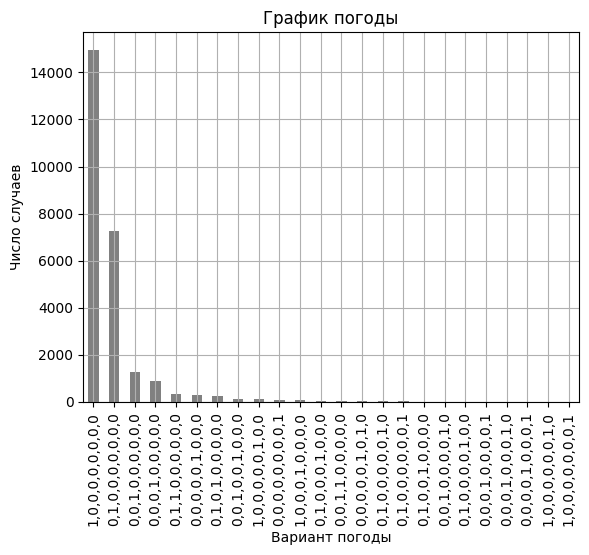

In [33]:
# Построим график.

weather_df_count.plot(kind='bar', grid=True, color = 'grey')
plt.title('График погоды')
plt.xlabel('Вариант погоды')
plt.ylabel('Число случаев');

In [34]:
# Подготовим датафрейм с погодой для OHE.

weather_ohe = pd.DataFrame()

weather_ohe['id'] = df['id'].copy()

In [35]:
weather_ohe[my_list] = df.apply(return_w,
                                    axis=1).str.split(',',
                                                      expand=True).astype(int)

weather_ohe.info()
weather_ohe.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25665 entries, 0 to 25664
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype
---  ------                 --------------  -----
 0   id                     25665 non-null  int64
 1   Ясно                   25665 non-null  int32
 2   Пасмурно               25665 non-null  int32
 3   Снегопад               25665 non-null  int32
 4   Дождь                  25665 non-null  int32
 5   Температура ниже -30С  25665 non-null  int32
 6   Метель                 25665 non-null  int32
 7   Температура выше +30С  25665 non-null  int32
 8   Ураганный ветер        25665 non-null  int32
 9   Туман                  25665 non-null  int32
dtypes: int32(9), int64(1)
memory usage: 1.1 MB


,id,Ясно,Пасмурно,Снегопад,Дождь,Температура ниже -30С,Метель,Температура выше +30С,Ураганный ветер,Туман
0,2869171,1,0,0,0,0,0,0,0,0
1,2320091,0,1,0,0,0,0,0,0,0
2,2321011,1,0,0,0,0,0,0,0,0
3,2576909,1,0,0,0,0,0,0,0,0
4,2575209,1,0,0,0,0,0,0,0,0


In [36]:
# Посмотрим описательные статистики.

weather_ohe.describe().T

,count,mean,std,min,25%,50%,75%,max
id,25665.0,2.452826e+06,209119.926683,2307859.0,2314275.0,2320691.0,2602462.0,2956533.0
Ясно,25665.0,5.892461e-01,0.491980,0.0,0.0,1.0,1.0,1.0
Пасмурно,25665.0,3.062537e-01,0.460945,0.0,0.0,0.0,1.0,1.0
Снегопад,25665.0,6.791350e-02,0.251602,0.0,0.0,0.0,0.0,1.0
Дождь,25665.0,4.453536e-02,0.206285,0.0,0.0,0.0,0.0,1.0
Температура ниже -30С,25665.0,2.571596e-03,0.050647,0.0,0.0,0.0,0.0,1.0
Метель,25665.0,1.722190e-02,0.130100,0.0,0.0,0.0,0.0,1.0
Температура выше +30С,25665.0,3.935320e-03,0.062610,0.0,0.0,0.0,0.0,1.0
Ураганный ветер,25665.0,1.597506e-03,0.039938,0.0,0.0,0.0,0.0,1.0
Туман,25665.0,3.584648e-03,0.059766,0.0,0.0,0.0,0.0,1.0


## Графики

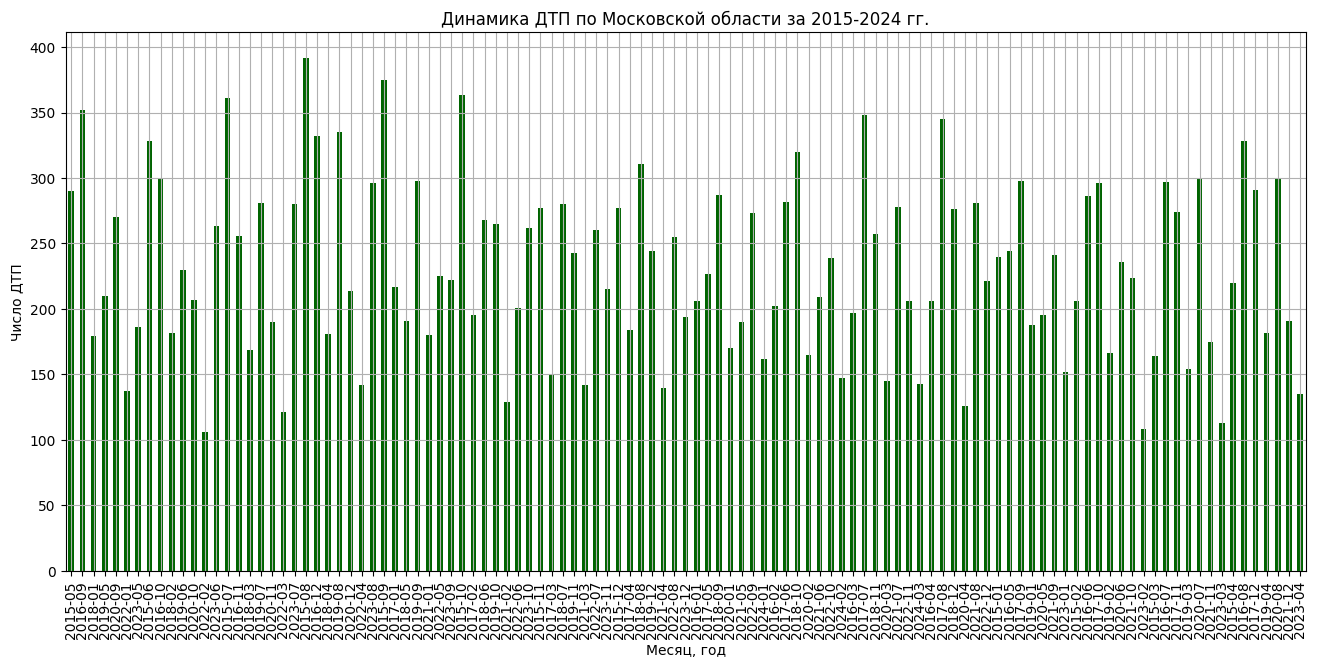

In [37]:
# Посмотрим число ДТП по месяцам.

weather_plot = df['datetime'].dt.to_period("M").sort_values().value_counts(
    sort=False)
weather_plot.plot(kind='bar', grid=True, figsize=[16, 7],color = 'darkgreen')
plt.title('Динамика ДТП по Московской области за 2015-2024 гг.')
plt.xlabel('Месяц, год')
plt.ylabel('Число ДТП');

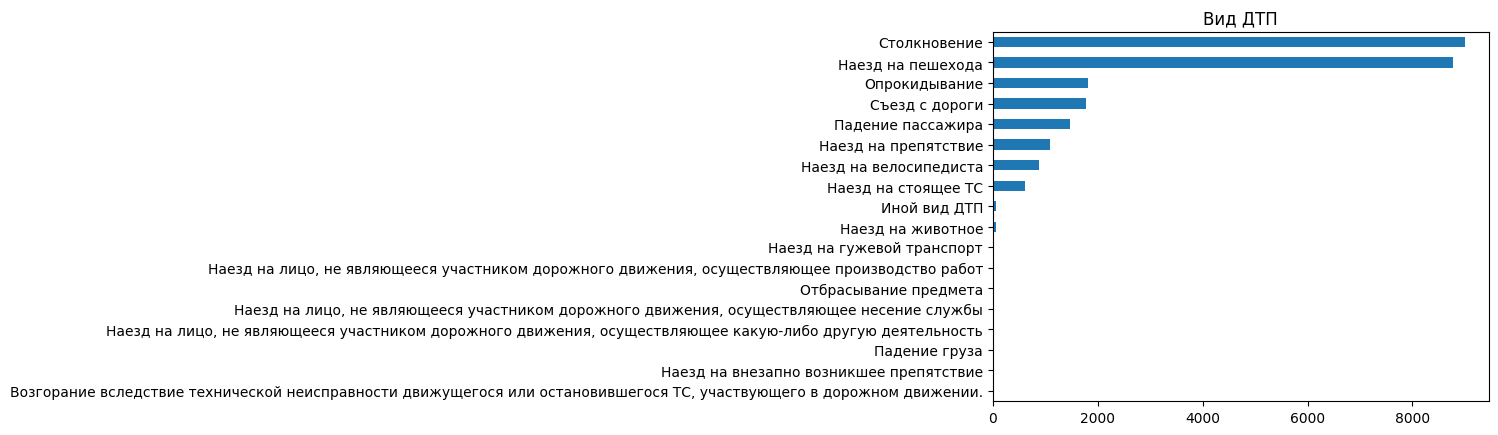

In [38]:
df['category'].value_counts(ascending = True).plot(kind = 'barh')
plt.title('Вид ДТП');

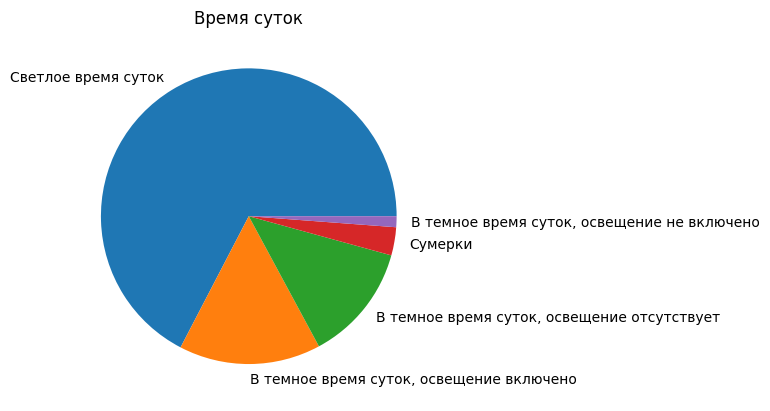

In [39]:
df['light'].value_counts().plot(kind = 'pie', label = '');
plt.title('Время суток');

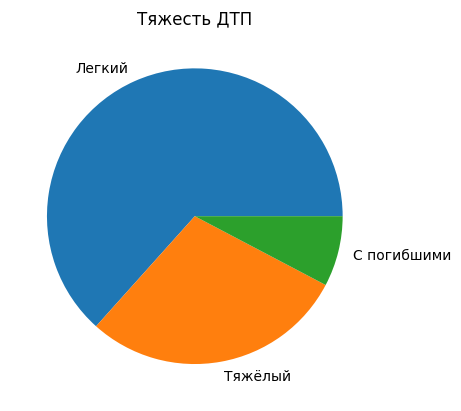

In [40]:
# Посмотрим тяжесть ДТП.

df['severity'].value_counts().plot(kind = 'pie', label = '')
plt.title('Тяжесть ДТП');

In [41]:
# Процентное соотношение.

df['severity'].value_counts(normalize= True).round(2)*100

Легкий         63.0
Тяжёлый        29.0
С погибшими     8.0
Name: severity, dtype: float64

In [42]:
# Посмотрим число погибших.

dead_df = df[['datetime','dead_count', 'injured_count']].copy()

dead_df['datetime_M'] = dead_df['datetime'].dt.to_period("M")

dead_df=dead_df.sort_values(by = ['datetime_M'])

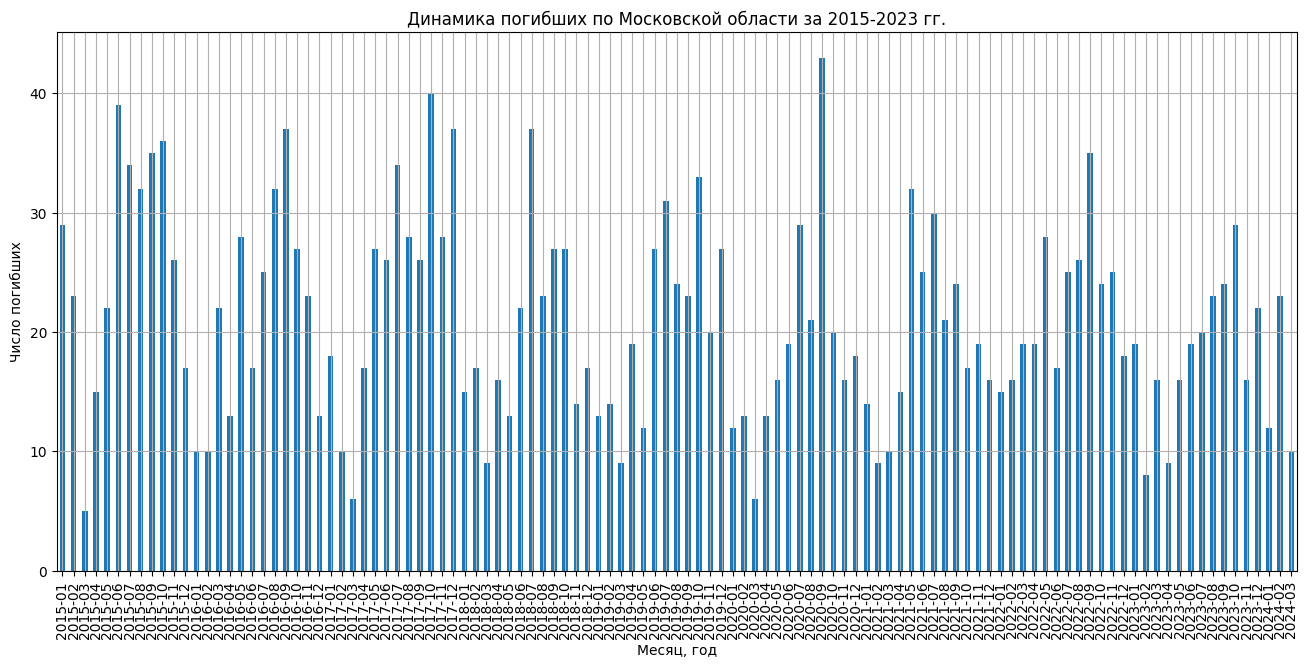

In [43]:
dead_df.groupby('datetime_M')['dead_count'].sum().plot(kind='bar',
                                                       grid=True,
                                                       figsize=[16, 7]
                                                      )

plt.title('Динамика погибших по Московской области за 2015-2023 гг.')
plt.xlabel('Месяц, год')
plt.ylabel('Число погибших');

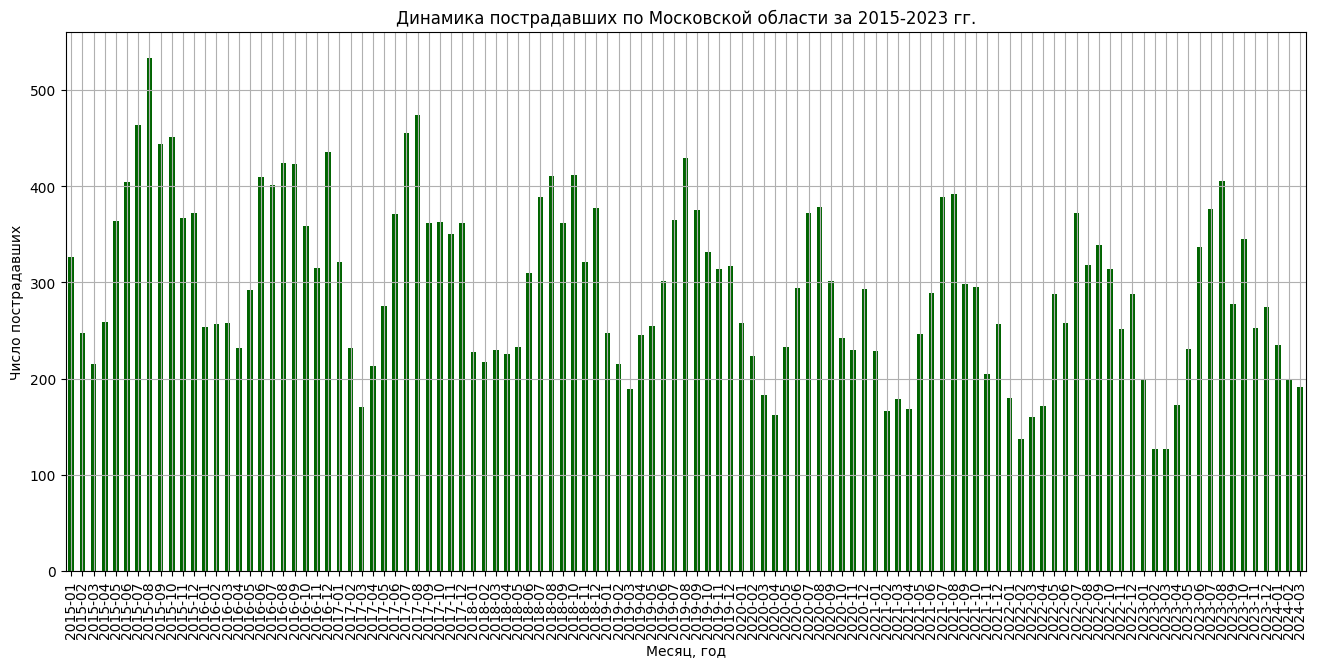

In [44]:
# Смотрим число пострадавших.

dead_df.groupby('datetime_M')['injured_count'].sum().plot(kind='bar',
                                                          grid=True,
                                                          color = 'darkgreen',
                                                          figsize=[16, 7])

plt.title('Динамика пострадавших по Московской области за 2015-2023 гг.')
plt.xlabel('Месяц, год')
plt.ylabel('Число пострадавших');

## Рефакторинг

In [47]:
# Пишем функцию, которая вернет нам обработанный датафрейм


def return_true_dfs(path):
    geo_json = read_geojson(os.path.join('dtp', path))  # Замена path

    df = pd.json_normalize(geo_json['features'])  # Получаем общий датафрейм

    # Обрабатываем название колонок

    df = df.drop([col for col in df.columns if 'type' in col], axis=1)
    df.columns = [col.split('.')[-1] for col in df.columns]

    # Сразу снижаем размерность id.
    # Чем ниже размерность int, тем меньше ячеек памяти выделяется.
    # Тем меньший диапзон чисел будет хранится, будьте внимательны.
    # NB - не изменяйте размерность float!!!

    df['id'] = df['id'].astype('int32')

    # Датафрейм для машин.

    df_vehicles = normalize_json_to_data(df, 'vehicles').reset_index(drop=True)

    # Датафрейм для пассажиров машин.

    df_vehicles_participants = normalize_json_to_data(
        df_vehicles, 'participants').reset_index(drop=True)

    # Датафрейм для пешеходов.

    # Дополнительно удалим все пустые строки, так как там нет пешеходов.

    df_footer = normalize_json_to_data(df,
                                       'participants').reset_index(drop=True)

    # Удяляем участников в транспортном средстве.

    df_vehicles = df_vehicles.drop(['participants'], axis=1)
    df = df.drop(['participants', 'vehicles'], axis=1)

    #  Объединим таблицы df_footer и df_vehicles_participants удалим пустые роли.

    df_foot_part = pd.concat( 
        [df_vehicles_participants,
         df_footer]).copy().reset_index(drop=True)

    # Возвращаем полученные датасеты.

    return df, df_vehicles, df_foot_part

In [48]:
data_base, data_vehicles,  df_foot_part = return_true_dfs(list_file[0])

In [49]:
# _ означает, что данная переменная нам не нужна
# n=1 устанавливает по умолчание значение = 1
def return_df(path, n=1):
    
    # Смысл работе прост, n - переключатель датафрейма.
    if n == 1:
        df, _, _ = return_true_dfs(path)
        
    if n == 2:
        _, df, _ = return_true_dfs(path)
        
    if n == 3:
        _, _, df = return_true_dfs(path)

    return df

In [63]:
return_df(list_file[0]).head()

,coordinates,id,tags,light,lat,long,nearby,region,scheme,address,weather,category,datetime,severity,dead_count,injured_count,parent_region,road_conditions,participants_count,participant_categories
0,"[83.7879, 53.3912]",2869171,[Дорожно-транспортные происшествия],Светлое время суток,53.391200,83.787900,[Жилые дома индивидуальной застройки],Барнаул,830,None,[Ясно],Наезд на пешехода,2023-05-24 19:30:00,Легкий,0,1,Алтайский край,[Сухое],2,"[Все участники, Пешеходы, Мотоциклисты]"
1,"[83.666389, 53.345833]",2320091,"[Дорожно-транспортные происшествия, ДТП и пост...",Светлое время суток,53.345833,83.666389,"[Многоквартирные жилые дома, Внутридворовая те...",Барнаул,880,"г Барнаул, ул Сиреневая, 11",[Пасмурно],Иной вид ДТП,2015-09-16 13:00:00,Легкий,0,1,Алтайский край,[Сухое],2,"[Дети, Все участники]"
2,"[83.39688, 53.19706]",2321011,"[Дорожно-транспортные происшествия, ДТП и пост...",Светлое время суток,53.197060,83.396880,"[Административные здания, Остановка общественн...",Барнаул,960,"г Барнаул, ул Попова, 165",[Ясно],Падение пассажира,2017-08-25 15:30:00,Легкий,0,1,Алтайский край,[Сухое],3,"[Дети, Все участники]"
3,"[83.7142, 53.3764]",2576909,[Дорожно-транспортные происшествия],Светлое время суток,53.376400,83.714200,"[Выезд с прилегающей территории, Административ...",Барнаул,130,"г Барнаул, ул Петра Сухова, 83 А",[Ясно],Столкновение,2021-05-29 19:40:00,Тяжёлый,0,1,Алтайский край,"[Сухое, Отсутствие, плохая различимость горизо...",3,"[Все участники, Мотоциклисты]"
4,"[83.794366, 53.343071]",2575209,[Дорожно-транспортные происшествия],Светлое время суток,53.343071,83.794366,"[Многоквартирные жилые дома, Жилые дома индиви...",Барнаул,500,"г Барнаул, ул Партизанская, 26",[Ясно],Столкновение,2021-05-25 16:40:00,Легкий,0,1,Алтайский край,"[Сухое, Отсутствие, плохая различимость горизо...",2,[Все участники]


## Объединение всех файлов в 3 pickle

## Все три файла готовы, можно работать

## Открываем файлы, смотрим что получилось

In [9]:
# Образец для загрузки

with open("data_base.pickle", 'rb') as file:
    data_base = pickle.load(file)

In [11]:
data_base.head().T

,0,1,2,3,4
coordinates,"[83.7879, 53.3912]","[83.666389, 53.345833]","[83.39688, 53.19706]","[83.7142, 53.3764]","[83.794366, 53.343071]"
id,2869171,2320091,2321011,2576909,2575209
tags,[Дорожно-транспортные происшествия],"[Дорожно-транспортные происшествия, ДТП и пост...","[Дорожно-транспортные происшествия, ДТП и пост...",[Дорожно-транспортные происшествия],[Дорожно-транспортные происшествия]
light,Светлое время суток,Светлое время суток,Светлое время суток,Светлое время суток,Светлое время суток
lat,53.3912,53.345833,53.19706,53.3764,53.343071
long,83.7879,83.666389,83.39688,83.7142,83.794366
nearby,[Жилые дома индивидуальной застройки],"[Многоквартирные жилые дома, Внутридворовая те...","[Административные здания, Остановка общественн...","[Выезд с прилегающей территории, Административ...","[Многоквартирные жилые дома, Жилые дома индиви..."
region,Барнаул,Барнаул,Барнаул,Барнаул,Барнаул
scheme,830,880,960,130,500
address,None,"г Барнаул, ул Сиреневая, 11","г Барнаул, ул Попова, 165","г Барнаул, ул Петра Сухова, 83 А","г Барнаул, ул Партизанская, 26"


Таким образом мы получили 3 датафрейма:

df - общий датафрейм по ДТП.

* 'coordinates' - координаты  , 
* 'id' - идентификатор, 
* 'tags' - показатели с официального сайта ГИБДД, 
* 'light' - время суток, 
* 'lat' - широта, 
* 'long' - долгота, 
* 'nearby' - объекты рядом, 
* 'region' - город/район и т.д.,
* 'scheme' - схема ДТП (нет в описании), 
* 'address' - адрес ДТП, 
* 'weather' - погодные условия, 
* 'category' - тип ДТП 
* 'datetime' - дата и время ДТП, 
* 'severity' - тяжесть состояния,
* 'vehicles' транспортное средство, 
* 'dead_count' - погибшие, 
* 'participants' - участники в транспортном средстве, 
* 'injured_count' - количество пострадавших,
* 'parent_region' - центральный регион, 
* 'road_conditions' - условия дороги, 
* 'participants_count' - количество участников ДТП,
* 'participant_categories' - категории участников

df_vehicles - данные по транспортным средствам.

* id - идентификатор
* year - год выпуска
* brand - а/м компания
* color - цвет а/м
* model - модель машины
* category - категория транспортного средства

df_foot_part - данные по пассажирам ТС и пешеходам.

* id - идентификатор
* role - роль в ДТП
* gender - половая принадлежность
* violations - нарушение
* health_status - вред здоровью
* years_of_driving_experience - стаж вождения